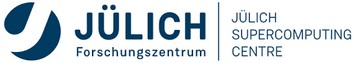
Author: [Jens Henrik Göbbert](mailto:j.goebbert@fz-juelich.de)
------------------------------------

# Sanity Check
This notebook checks if the available general tutorials run without errors.  

This particulary tests the installed python packages and their interoperability for standard features and examples. Running these checks can take **a lot of time** and there for will not finish in the max. cpu-time we provide for a process on a login node. Hence the jupyter kernel for this notebook will eventually be killed by the system. These Sanity Checks are primarily usefull for system administrators.  

If you want to run them anyway - ensure your Jupyter is running as a **batch job** with far more compute time available.

-----------------------

### Set Path to Tutorials

In [ ]:
import os

# alternative 1: create new directory and download
from git import Repo
dwnldir = os.getenv('PROJECT', os.getenv('HOME', '.')) + '/' + os.getenv('USER', '') 
repo = Repo.clone_from("https://gitlab.version.fz-juelich.de/jupyter4jsc/j4j_notebooks.git", dwnldir)
workdir = dwnldir + '/' + 'j4j_notebooks'

# alternative 2: use existing download
#workdir = '/p/project/ccstvs/' + os.getenv('USER', '')  + '/j4j_notebooks'

print(workdir)

### Define Funktions for later Sanity Check

In [ ]:
from typing import Any, Tuple, Dict, Mapping
from collections import defaultdict
from nbformat import NotebookNode

def count_source(source: str) -> Tuple[int, int, int]:
    """Count number of non-blank lines, words, and non-whitespace characters.

    :param source: string to count
    :return: number of non-blank lines, words, and non-whitespace characters
    """
    lines = [line for line in source.split('\n') if line and not line.isspace()]
    words = source.split()
    chars = ''.join(words)

    return len(lines), len(words), len(chars)

REQUIRED_NB_FIELDS = {"metadata", "nbformat_minor", "nbformat", "cells"}
REQUIRED_NB_METADATA_FIELDS = {"kernelspec", "language_info"}
CELL_TYPES = ('markdown', 'code', 'raw', )
REQUIRED_CELL_FIELDS = {
    'markdown': {"cell_type", "metadata", "source"},
    'code': {"cell_type", "metadata", "source", "execution_count", "outputs"},
    'raw': {"cell_type", "metadata", "source"}
}
OPTIONAL_CELL_FIELDS = {
    'markdown': {"attachments"},
    'code': set(),
    'raw': {"attachments"}
}
OPTIONAL_OUTPUT_TYPES = {
    'execute_result': {'data', 'metadata' ,'execution_count'},
    'stream': {'name', 'text'},
    'display_data': {'data', 'metadata', },
    'error': {'ename', 'evalue', 'traceback'},
}

CELL_STATISTICS = (
    'cell_types',  #: cell type counts
    'sources', #: cell sources counts
    'cell_metadata',  #: cell metadata counts, including separate ``tags``
    'cell_attachments',  #: cell attachment MIME type counts, and total
    'code_execution',  #: code cell execution count statistics
    'code_outputs',  #: code cell counts per output_type, subcounts per ``stream`` and ``error``, and total
    'cell_extra',  #: counts for extra (unknown) fields in cells
)

# dictionary keys for source statistics
EMPTY_SOURCES = 'total empty sources'
SOURCE_LINES = 'total source lines'
SOURCE_WORDS = 'total source words'
SOURCE_CHARS = 'total source chars'
EMPTY_SOURCES_MD = 'markdown empty sources'
SOURCE_LINES_MD = 'markdown source lines'
SOURCE_WORDS_MD = 'markdown source words'
SOURCE_CHARS_MD = 'markdown source chars'
EMPTY_SOURCES_CODE = 'code empty sources'
SOURCE_LINES_CODE = 'code source lines'
SOURCE_WORDS_CODE = 'code source words'
SOURCE_CHARS_CODE = 'code source chars'
EMPTY_SOURCES_RAW = 'raw empty sources'
SOURCE_LINES_RAW = 'raw source lines'
SOURCE_WORDS_RAW = 'raw source words'
SOURCE_CHARS_RAW = 'raw source chars'

def nb_cell_stats(nb: NotebookNode) -> Dict[str, Dict[str, int]]:
    """Count occurrences of various elements in notebook cells.

    :param nb: notebook to inspect
    :return: dictionary of dictionaries with counts per section;
        each section has its own key; see CELL_STATISTICS
    """
    # process the notebook cells
    result = {key: defaultdict(int) for key in CELL_STATISTICS}

    # traverse all cells and gather statistics
    for index, cell in enumerate(nb.cells):  # index can be used for debug output
        result['cell_types']['total cell count'] += 1  # count all cells
        ct = cell.cell_type
        result['cell_types'][ct] += 1  # count each cell type

        # compute source statistics
        lines, words, chars = count_source(cell.source)  # cell.source should always be present
        empty_cell = chars == 0
        if empty_cell:
            result['sources'][EMPTY_SOURCES] += 1
            if ct == 'markdown':
                result['sources'][EMPTY_SOURCES_MD] += 1
            elif ct == 'code':
                result['sources'][EMPTY_SOURCES_CODE] += 1
            elif ct == 'raw':
                result['sources'][EMPTY_SOURCES_RAW] += 1
        if chars:
            result['sources'][SOURCE_LINES] += lines
            result['sources'][SOURCE_WORDS] += words
            result['sources'][SOURCE_CHARS] += chars
            if ct == 'markdown':
                result['sources'][SOURCE_LINES_MD] += lines
                result['sources'][SOURCE_WORDS_MD] += words
                result['sources'][SOURCE_CHARS_MD] += chars
            elif ct == 'code':
                result['sources'][SOURCE_LINES_CODE] += lines
                result['sources'][SOURCE_WORDS_CODE] += words
                result['sources'][SOURCE_CHARS_CODE] += chars
            elif ct == 'raw':
                result['sources'][SOURCE_LINES_RAW] += lines
                result['sources'][SOURCE_WORDS_RAW] += words
                result['sources'][SOURCE_CHARS_RAW] += chars

        # count each metadata key
        for attr in cell.metadata:  # cell.metadata should always be present
                result['cell_metadata'][attr] += 1

        # count each tag in tags metadata
        if 'tags' in cell.metadata:
            for tag in cell.metadata.tags:
                result['cell_metadata']['tag ' + tag] += 1

        # count each attachment mime type
        if 'attachments' in cell:
            result['cell_attachments']['total count of cells with attachments'] += 1
            for attachment in cell.attachments.values():
                for key in attachment:
                    result['cell_attachments']['total attachments count'] += 1
                    result['cell_attachments'][key] += 1

        # count non-standard fields in cells
        for field in cell:
            if field not in REQUIRED_CELL_FIELDS[ct].union(OPTIONAL_CELL_FIELDS[ct]):
                result['cell_extra'][field] += 1

    return result

from colorama import Fore, Back, Style
DEFAULT_WIDTH = 10
def print_dict(d: Dict[str, Any], header: str=None, width: int=DEFAULT_WIDTH) -> None:
    """Print dictionary d with section header.

    :param d: dictionary to print
    :param header: header of the table
    :param width: width of the left column
    """
    if d:
        if header:
            print('{}:'.format(header))
        for key in sorted(d):
            if key == 'raw':
                style = Fore.RED
            else:
                style = ''
            left = str(d[key])
            print(style + '  {:>{}} {}'.format(left, width, key) + Style.RESET_ALL)
            
from pathlib import Path
from nbformat import NotebookNode
from typing import List, Union
import nbformat
import sys

def read_nb(nb_path: Path) -> Union[None, NotebookNode]:
    """Read notebook from given path, and return it.
    Uses ``args.debug``: in debug mode, a read error results in an exception, else it returns ``None``.

    :param nb_path: path to read from
    :param args: to check debug mode
    :return: notebook read from ``nb_path`` or None if reading failed``
    """
    try:
        nb = nbformat.read(nb_path.open(encoding='utf-8'), as_version=4)
    except Exception as e:
        ename = type(e).__name__
        print('Reading of "{}" failed ({}):\n  {}'.format(nb_path.name, ename, e), file=sys.stderr)
        return None

    return nb

### Run the Sanity Check

In [ ]:
import os
import papermill as pm
from papermill.exceptions import PapermillExecutionError

failed_notebooks = list()
dirbase = workdir + '/001-Jupyter/001-Tutorials/'
for dirpath, dirs, files in os.walk(dirbase):
    dirs.sort()
    if os.path.basename(dirpath).startswith('.'):
        continue
    for filename in sorted(files):
        if filename.endswith('.ipynb') and not filename.startswith('papermill_'):
            print(os.path.join(dirpath,filename))
            if filename == "SanityCheck-Tutorials.ipynb":
                continue
            if filename.endswith('_skip.ipynb'):
                print("... skipping")
                continue
            try:
                os.chdir(dirpath)
                nb_path = os.path.join(dirpath, filename)

                # get notebook statistics
                nb = read_nb(Path(nb_path))
                cell_stats = nb_cell_stats(nb)
                print_dict(cell_stats['cell_types'], "Cell types")
                print_dict(cell_stats['sources'], "Cell sources")
                print_dict(cell_stats['cell_metadata'], "Cell metadata fields")
                print_dict(cell_stats['cell_attachments'], "Cell attachments")

                # execute notebook
                try:
                    nb = pm.execute_notebook(
                        nb_path,
                        os.path.join(dirpath, 'papermill_' + filename),
                        #kernel_name="Python3"
                    )
                except:
                    print("FAILED !!!!")

                os.chdir(dirbase)
            except PapermillExecutionError as e:
                failed_notebooks.append([os.path.join(dirpath, filename), e.evalue])
                print(e.evalue)

# Check Results

In [ ]:
failed_notebooks

# Clean Up

In [ ]:
import os
import papermill as pm
from papermill.exceptions import PapermillExecutionError

failed_notebooks = list()
dirbase = workdir + '/001-Jupyter/001-Tutorials/'
for dirpath, dirs, files in os.walk(dirbase):
    if os.path.basename(dirpath).startswith('.'):
        continue
    for filename in files:
        if filename.endswith('.ipynb') and filename.startswith('papermill_'):
            nb_path = os.path.join(dirpath,filename)
            print(nb_path)
            os.remove(nb_path)

## Remove Output

In [ ]:
import os
import papermill as pm
from papermill.exceptions import PapermillExecutionError

failed_notebooks = list()
dirbase = workdir + '/001-Jupyter/001-Tutorials/'
for dirpath, dirs, files in os.walk(dirbase):
    if os.path.basename(dirpath).startswith('.'):
        continue
    for filename in files:
        if filename.endswith('.ipynb') and not filename.startswith('papermill_'):
            nb_path = os.path.join(dirpath,filename)
            print(nb_path)            
            !jupyter nbconvert --clear-output --inplace "{nb_path}"